# Access and plot CMIP6 data directly from the CMIP archive

This is the second way of accessing the data, see https://nbviewer.jupyter.org/github/pangeo-data/pangeo-cmip6-examples/blob/master/search_and_load_with_esgf_opendap.ipynb

This notebooks shows how to search and load data via Earth System Grid Federation infrastructure. This infrastructure works great and is the foundation of the CMIP6 distribution system.

The main technologies used here are the ESGF search API, used to figure out what data we want, and OPeNDAP, a remote data access protocol over HTTP.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

#xr.set_options(display_style='html') 
#= not really neededdisplay_style: display style to use in jupyter for xarray objects. Default: 'html'.

#BG the following two lines are not strictly needed:
#%matplotlib inline 
#https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline
#%config InlineBackend.figure_format = 'retina'  
#https://stackoverflow.com/questions/42611694/configure-the-backend-of-ipython-to-use-retina-display-mode-with-code

The lower script is a definition of a module, that searches through the CMIP6 archive on "esgf" nodes of the server at Lawrence Livermore National Lab: https://esgf-node.llnl.gov/esg-search/search

See in the code further below the structure of the call: 
esgf_search(activity_id='CFMIP', table_id='Amon', variable_id='clivi', experiment_id='amip-p4K', source_id="BCC-CSM2-MR")

activity_id  = which group of experiments (CMIP, CFMIP, HighResMIP...)
table_id     = frequency with which the variable is in the output (e.g. Amon = monthly averages)
variable_id  = variable name (e.g. clivi = ice water path)
experiment_id= name of the experiment (e.g. amip-p4K)
source_id    = model name (e.g. BCC-CSM2-MR)


In [36]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

Here taken the models that at that point it time, in early June 2021 had the variable "clivi" (ice water path) available for the AMIP reference and amip 4K simulation
(amip-p4K = AMIP with uniform 4K SST increase)

Please check if more models have the right data available, we don't need to use all, but maybe 20+ would be nice to have. How do you do that? simply use for both amip and amip-p4K experiments
result_am = esgf_search(activity_id='CFMIP', table_id='Amon', variable_id='clivi', experiment_id='amip-p4K')

see experiment descriptions here: https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_experiment_id.html
(to add possibly also the HighResMip simulations? highresSST-p4K and highresSST-present)

In [37]:
model = ['BCC-CSM2-MR','CNRM-CM6-1','IPSL-CM6A-LR','MRI-ESM2-0','CanESM5','GISS-E2-1-G','GFDL-CM4','MIROC6','E3SM-1-0']
#CESM? NORESM...etc. may be available too
#amip-4k
result_4k=[]
for i in range(0,len(model)):
    print(model[i])
    result_am = esgf_search(activity_id='CFMIP', table_id='Amon', variable_id='clivi', experiment_id='amip-p4K',source_id=model[i])#, source_id="BCC-CSM2-MR")
    result_4k.append(result_am[0])# [0] => because only 1 ensemble per model for simplicity, to be generalized if needed

#amip
resultall=[]
for i in range(0,len(model)):
    print(model[i])
    result_am = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='clivi', experiment_id='amip',source_id=model[i])#, source_id="BCC-CSM2-MR")
    resultall.append(result_am[0])#only 1 ensemble per model

BCC-CSM2-MR
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&source_id=BCC-CSM2-MR&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
CNRM-CM6-1
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&source_id=CNRM-CM6-1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
IPSL-CM6A-LR
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&source_id=IPSL-CM6A-LR&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
MRI-ESM2-0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&source_id=MRI-ESM2-0&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
CanESM5
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMI

E3SM-1-0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=clivi&experiment_id=amip&source_id=E3SM-1-0&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=clivi&experiment_id=amip&source_id=E3SM-1-0&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=clivi&experiment_id=amip&source_id=E3SM-1-0&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=clivi&experiment_id=amip&source_id=E3SM-1-0&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=clivi&experiment_id=amip&source_id=E3SM-1-0&pro

Load Data with Xarray These are OPeNDAP endpoints. Xarray, together with the netCDF4 python library, allow lazy loading.

I just did 2 loops; could be rewritten using 1 loop only.

In [38]:
amip4k_all=[]
for i in range(0,9):
    print(i)
    ds = xr.open_mfdataset(result_4k[i:i+1], combine='by_coords')
    amip4k_all.append(ds)

#amip
amip_all=[]
for i in range(0,9):
    print(i)
    dsa = xr.open_mfdataset(resultall[i:i+1], combine='by_coords')
    amip_all.append(dsa)

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


In order to be able to plot output of several different models consistently, we need to regrid them on the same latitude-longitude grid.
I am using the xe.Regridder (https://xesmf.readthedocs.io/en/latest/) with the "bilinear" interpolation to get to the common 2 x 2 deg grid. You may use other regridding methods too, I just chose the first one I found online.

In [39]:
#first define the new, uniform 2x2 deg grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 2.0)),
                     'lon': (['lon'], np.arange(0, 360, 2)),
                    }
                   )

amip4k_regrid=[]
amip_allmod_regrid=[]
for i in range(0,9):
    print(i)
    #here regridding
    regridder = xe.Regridder(amip4k_all[i], ds_out, 'bilinear')
    regridder2 = xe.Regridder(amip_all[i], ds_out, 'bilinear')
    reg_out = regridder(amip4k_all[i])
    reg_out2 = regridder2(amip_all[i])
    #append data, so that we get to an array we can easily plot
    amip4k_regrid.append(reg_out)
    amip_allmod_regrid.append(reg_out2)




0
1
2
3
4
5
6
7
8


Compute the zonal mean as in this example we would like to plot zonal mean values of ice water path from several models.

In [40]:
#amip4k
zonmean4k_all=[]
for i in range(0,9):
    print(i)
    zonmean4k=np.nanmean(amip4k_regrid[i].clivi,axis=((0,2)))
    zonmean4k_all.append(zonmean4k)
zonmean4k_all=np.array(zonmean4k_all)

zonmean_all=[]
for i in range(0,9):
    print(i)
    zonmean=np.nanmean(amip_allmod_regrid[i].clivi,axis=((0,2)))
    zonmean_all.append(zonmean)
zonmean_all=np.array(zonmean_all)

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


In [41]:
zonmean_all[0].shape #just a quick check of the dimension, to make sure all is good

(90,)

and now a sample plotting script => you can indeed do it also differently! \
e.g. it would be useful to scale the x-axis as a cosine of latitude

Also, a plot of relative anomalies of AMIP+4K simulations compared to the AMIP would be nice to see!

Text(0.5, 1.0, 'Ice water path in AMIP(solid) and AMIP+4K (dotted) simulations')

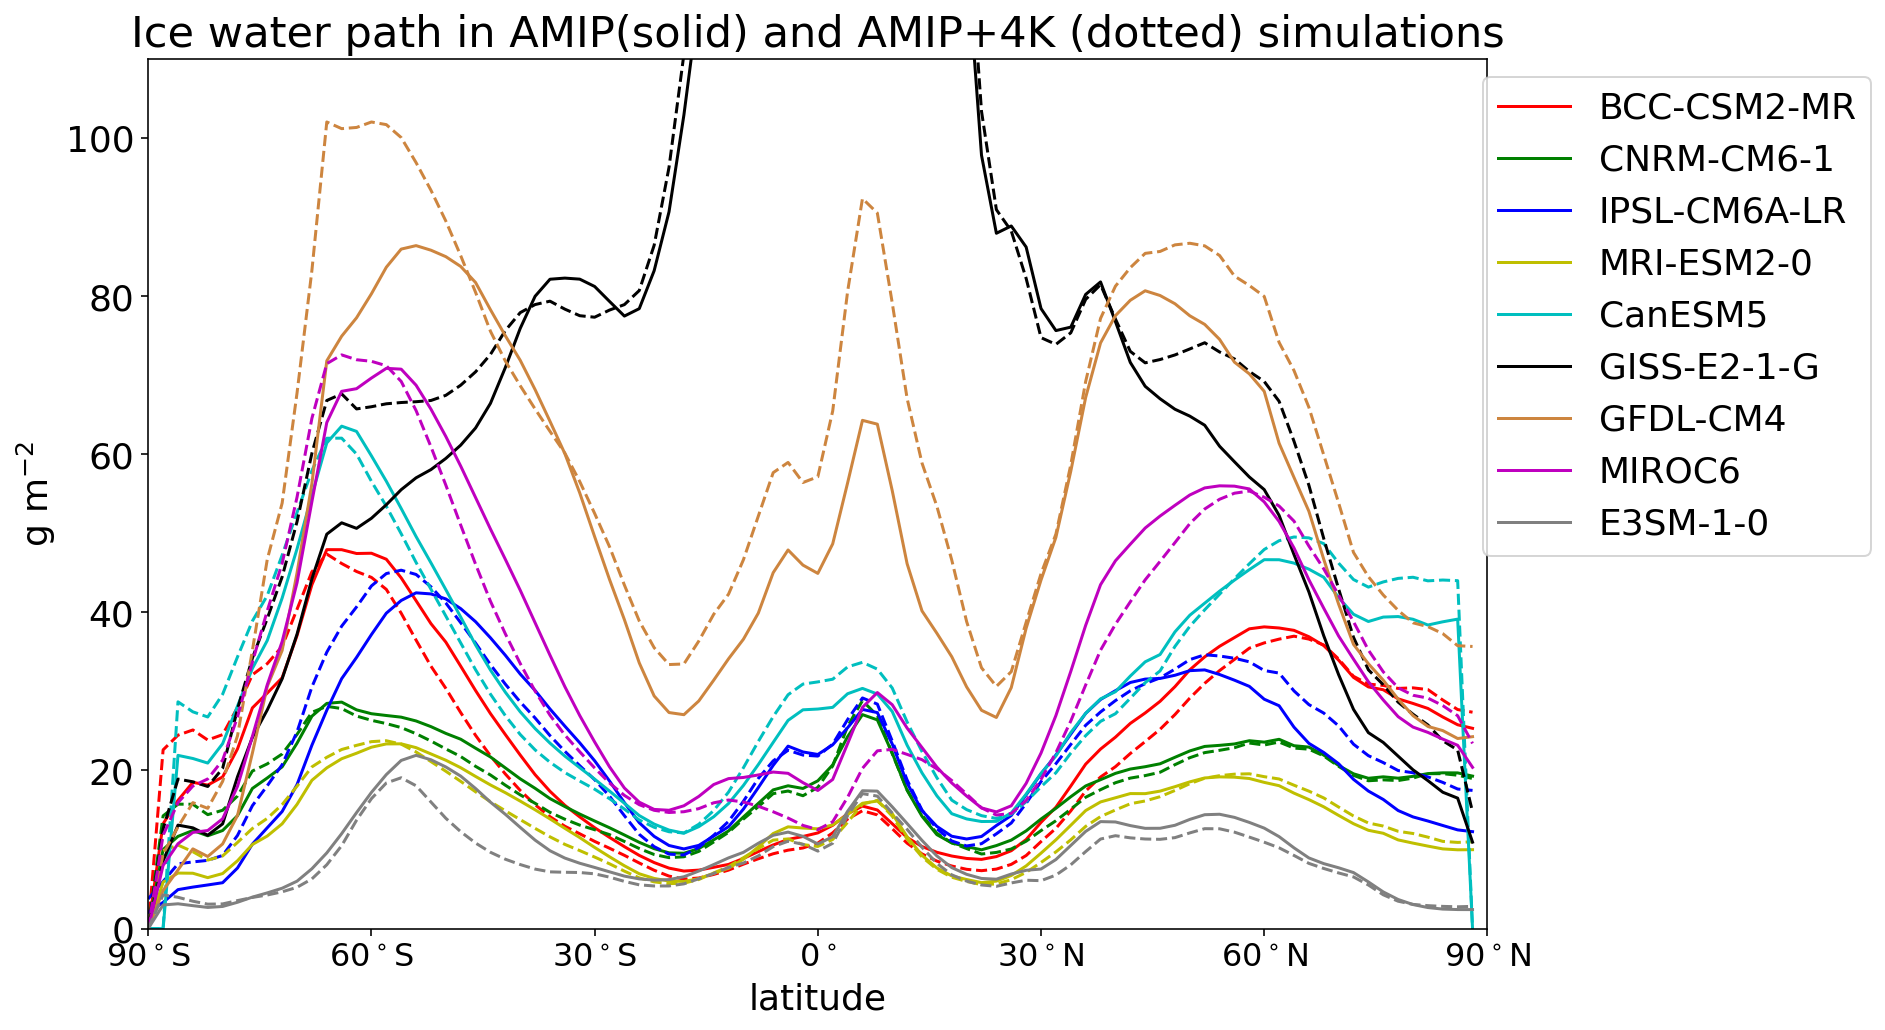

In [42]:
plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
model = ['BCC-CSM2-MR','CNRM-CM6-1','IPSL-CM6A-LR','MRI-ESM2-0','CanESM5','GISS-E2-1-G','GFDL-CM4','MIROC6','E3SM-1-0']

b=[]
xax=[-90.-60,-30,0,30,60,90]
cols=['r','g','b','y','c','k','peru','m','gray']
plt.figure(figsize=(12,8))
for i in range (0,9):
    b.append(plt.plot(zonmean_all[i]*1000,color=cols[i])[0])
    plt.plot(zonmean4k_all[i]*1000,linestyle='--',color=cols[i])
    
    
plt.legend(b,model,bbox_to_anchor=(1.3, 1))
plt.ylim(0,110)
plt.xlim(0,90)
plt.ylabel('g m$^{-2}$')
plt.xlabel('latitude')

plt.xticks([0,15,30,45,60,75,90],('90$^\circ$S','60$^\circ$S','30$^\circ$S',\
    '0$^\circ$','30$^\circ$N','60$^\circ$N','90$^\circ$N'),fontsize=16)

plt.title('Ice water path in AMIP(solid) and AMIP+4K (dotted) simulations')

#save figure
#plt.savefig('/Users/Blaz/Documents/wien_021/CMIP/plots/IWP_zonavg_amip_amip4k.pdf',dpi=200,bbox_inches='tight')

# How to search the CMIP6 archive

Here is an example of a search: variable 'clivi' for 'amip-p4K' experiment

In [19]:
test_search = esgf_search(activity_id='CFMIP', table_id='Amon', variable_id='clivi', experiment_id='amip-p4K')

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CFMIP&table_id=Amon&variable_id=clivi&experiment_id=amip-p4K&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=40


In [31]:
len(test_search) #check the size of the list

41

In [34]:
test_search1 #check the what is in this list => are more models available now?

array(['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CFMIP/BCC/BCC-CSM2-MR/amip-p4K/r1i1p1f1/Amon/clivi/gn/v20190807/clivi_Amon_BCC-CSM2-MR_amip-p4K_r1i1p1f1_gn_197901-201412.nc',
       'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CFMIP/CNRM-CERFACS/CNRM-CM6-1/amip-p4K/r1i1p1f2/Amon/clivi/gr/v20190820/clivi_Amon_CNRM-CM6-1_amip-p4K_r1i1p1f2_gr_197901-201412.nc',
       'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CFMIP/IPSL/IPSL-CM6A-LR/amip-p4K/r1i1p1f1/Amon/clivi/gr/v20180906/clivi_Amon_IPSL-CM6A-LR_amip-p4K_r1i1p1f1_gr_197901-201412.nc',
       'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CFMIP/MRI/MRI-ESM2-0/amip-p4K/r1i1p1f1/Amon/clivi/gn/v20190625/clivi_Amon_MRI-ESM2-0_amip-p4K_r1i1p1f1_gn_197901-201412.nc',
       'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CFMIP/NCAR/CESM2/amip-p4K/r1i1p1f1/Amon/clivi/gn/v20190302/clivi_Amon_CESM2_amip-p4K_r1i1p1f1_gn_197901-201312.nc',
       'http://cmip.bcc.cma.cn/thredds/dodsC/cmip6_data/CFMIP/B